# MLP

Same as MLP 17 but do training Gudenas style followed by fair test. Essentially, train on the easy/extreme cases, validate on all cases. 

Coding RNA. MLP with one neuron. All K-mers, K=4, one byte counts with cap 255. Threshold=one_z for training, but fair test with Threshold=mean. No scaling. 5-fold CV. RCI from cell line 0 = A549.

Cross validation acc mean 66.72% (+/- 3.90%) on binary classification of all mRNA. Not as good as training on all cases -- 68.26% (+/- 1.13%) -- though the difference is not significant.

For comparison with MLP 17, still using 20 epochs, though that is too many.


## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-21 09:32:40.826515
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization
from sklearn.preprocessing import StandardScaler

dt='float32'
tf.keras.backend.set_floatx(dt)

tf.random.set_seed(42) # reproducible training sessions?

from KmerCounter import KmerCounter
ALPHABET_SIZE=4
K=4
counter=KmerCounter(K)
VOCABULARY_SIZE = counter.get_vocabulary_size() 
print('K=',K,'alphabet size=',ALPHABET_SIZE,'vocabulary size=',VOCABULARY_SIZE)
from TrainValidSplit2 import Splitter2
EPOCHS=20
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

K= 4 alphabet size= 4 vocabulary size= 256


In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
COUNTS_FILE='CNRCI_coding_train_counts.K4.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    # Here is the joke model -- one neuron!
    mlp = keras.models.Sequential()
    one_layer = keras.layers.Dense(1, activation='sigmoid',dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    mlp.add(one_layer)
      
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-10-21 09:32:52.865271
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


2022-10-21 09:32:52.873797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data

In [7]:
# Data setup
print(datetime.now())
Kmer_counts_filepath = GENCODE_DIR+COUNTS_FILE
atlas_filepath = ATLAS_DIR+RCI_FILE

splitter=Splitter2()
splitter.load_counts_universe(Kmer_counts_filepath)
universe = splitter.get_gene_universe(atlas_filepath, CELL_LINE_NUMBER)
print(datetime.now())

2022-10-21 09:32:52.959405
Loaded values for cell line 0
Selected 10354 values out of 13930
2022-10-21 09:32:56.223902


## Train and validate with all K-mer counts

In [8]:
SCALING = False
def do_cross_validation(splitter,eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    data_partitions = splitter.get_train_valid_partitions(universe)
    for one_partition in data_partitions:
        train_genes,valid_genes = one_partition[0],one_partition[1]
        thresholdsT = splitter.choose_thresholds(train_genes,'one_z')
        X_train,y_train,train_ids = splitter.get_X_y(train_genes, thresholdsT)
        thresholdsV = splitter.choose_thresholds(train_genes,'mean')
        X_valid,y_valid,valid_ids = splitter.get_X_y(valid_genes, thresholdsV)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        fold += 1
        print('Fold',fold)
        print('Train sizes',len(X_train),len(y_train))
        print('Valid sizes',len(X_valid),len(y_valid))
        print('Thresholds for training',thresholdsT)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Thresholds for validation',thresholdsV)
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
    print()
    print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


2022-10-21 09:32:56.279549
2022-10-21 09:32:56.279997
splitting
Fold 1
Train sizes 12019 12019
Valid sizes 11253 11253
Thresholds for training (-1.266972910885237, 1.1401767974371442)
Train set ones/size 5469 / 12019
Thresholds for validation (-0.06339805672404636, -0.06339805672404636)
Valid set ones/size 6149 / 11253
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:32:56.427676
Epoch 1/20
376/376 [==============================] - 2s 4ms/step - loss: 1.1294 - accuracy: 0.7267 - val_loss: 1.1877 - val_accuracy: 0.6433
Epoch 2/20
376/376 [==============================] - 1s 3ms/step - loss: 0.5720 - accuracy: 0.7795 - val_loss: 1.0447 - val_accuracy: 0.6436
Epoch 3/20
376/376 [==============================] - 1s 3ms/step - loss: 0.4991 - accuracy: 0.7967 - val_loss: 1.0358 - val_accuracy: 0.6565
Epoch 4/20
376/376 [==============================] - 1s 3ms/step - loss: 0.4416 - accuracy: 0.8146 - val_loss: 0.9906 - val_accuracy: 0.6692
Epoch 5/20
376/376 [=========================

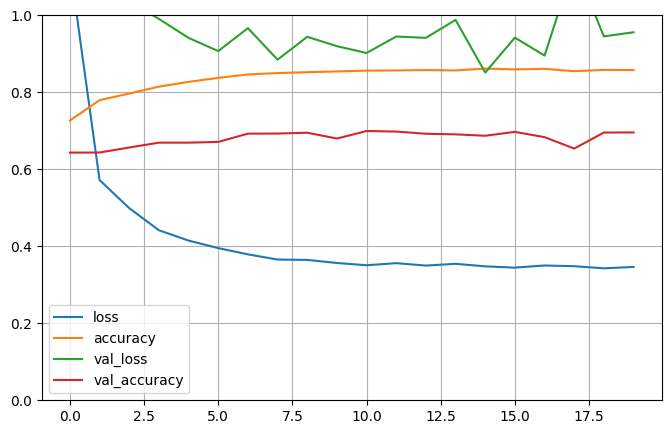

Compute valiation accuracy
2022-10-21 09:33:21.064784
accuracy: 69.56%
2022-10-21 09:33:21.509172
Fold 2
Train sizes 12068 12068
Valid sizes 10868 10868
Thresholds for training (-1.240869517441693, 1.1382361428048027)
Train set ones/size 5507 / 12068
Thresholds for validation (-0.051316687318445194, -0.051316687318445194)
Valid set ones/size 5710 / 10868
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:33:21.631529
Epoch 1/20
378/378 [==============================] - 2s 3ms/step - loss: 0.7350 - accuracy: 0.7535 - val_loss: 1.4485 - val_accuracy: 0.6244
Epoch 2/20
378/378 [==============================] - 1s 3ms/step - loss: 0.5449 - accuracy: 0.8025 - val_loss: 1.2360 - val_accuracy: 0.6259
Epoch 3/20
378/378 [==============================] - 1s 3ms/step - loss: 0.4609 - accuracy: 0.8212 - val_loss: 1.1445 - val_accuracy: 0.6546
Epoch 4/20
378/378 [==============================] - 1s 3ms/step - loss: 0.4157 - accuracy: 0.8390 - val_loss: 1.3062 - val_accuracy: 0.6066
Epoch 5/2

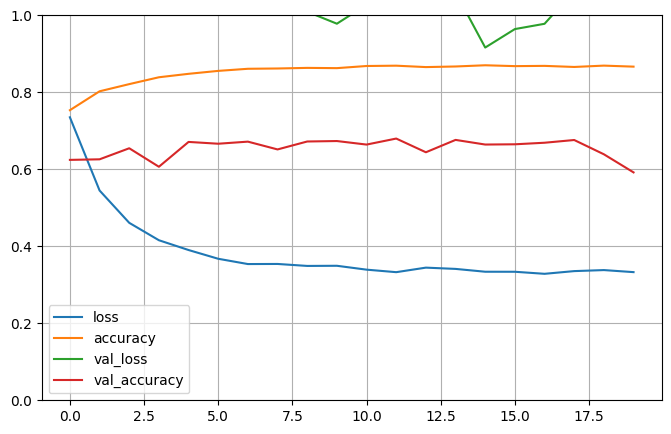

Compute valiation accuracy
2022-10-21 09:33:45.058091
accuracy: 59.19%
2022-10-21 09:33:45.596575
Fold 3
Train sizes 11991 11991
Valid sizes 10900 10900
Thresholds for training (-1.2410877135068596, 1.138897086169583)
Train set ones/size 5507 / 11991
Thresholds for validation (-0.051095313668638336, -0.051095313668638336)
Valid set ones/size 5625 / 10900
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:33:45.728021
Epoch 1/20
375/375 [==============================] - 2s 4ms/step - loss: 0.7151 - accuracy: 0.7540 - val_loss: 1.3041 - val_accuracy: 0.6505
Epoch 2/20
375/375 [==============================] - 1s 3ms/step - loss: 0.5382 - accuracy: 0.7942 - val_loss: 1.1462 - val_accuracy: 0.6793
Epoch 3/20
375/375 [==============================] - 1s 3ms/step - loss: 0.4559 - accuracy: 0.8224 - val_loss: 1.0110 - val_accuracy: 0.6619
Epoch 4/20
375/375 [==============================] - 1s 3ms/step - loss: 0.4095 - accuracy: 0.8358 - val_loss: 1.0165 - val_accuracy: 0.6863
Epoch 5/2

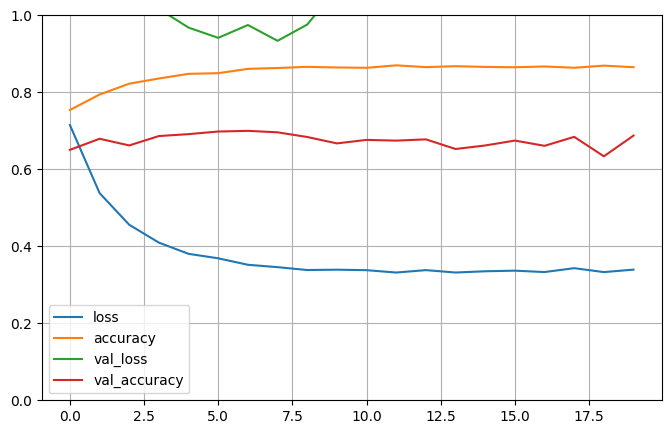

Compute valiation accuracy
2022-10-21 09:34:08.791265
accuracy: 68.75%
2022-10-21 09:34:09.394055
Fold 4
Train sizes 12235 12235
Valid sizes 10787 10787
Thresholds for training (-1.244761137161994, 1.149166980863346)
Train set ones/size 5557 / 12235
Thresholds for validation (-0.047797078149324, -0.047797078149324)
Valid set ones/size 5320 / 10787
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:34:09.499822
Epoch 1/20
383/383 [==============================] - 2s 4ms/step - loss: 0.7552 - accuracy: 0.7452 - val_loss: 1.3076 - val_accuracy: 0.6391
Epoch 2/20
383/383 [==============================] - 1s 3ms/step - loss: 0.5208 - accuracy: 0.7953 - val_loss: 1.1451 - val_accuracy: 0.6639
Epoch 3/20
383/383 [==============================] - 1s 3ms/step - loss: 0.4399 - accuracy: 0.8208 - val_loss: 1.0649 - val_accuracy: 0.6619
Epoch 4/20
383/383 [==============================] - 1s 3ms/step - loss: 0.4079 - accuracy: 0.8352 - val_loss: 0.9446 - val_accuracy: 0.6631
Epoch 5/20
383/3

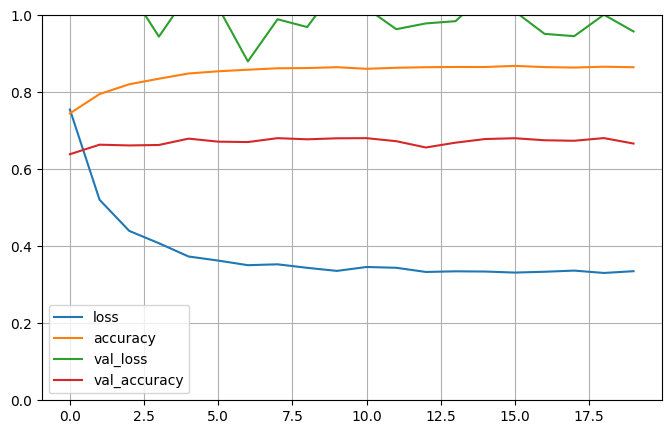

Compute valiation accuracy
2022-10-21 09:34:33.384994
accuracy: 66.68%
2022-10-21 09:34:33.830777
Fold 5
Train sizes 12030 12030
Valid sizes 10516 10516
Thresholds for training (-1.226430673293863, 1.1381054621929456)
Train set ones/size 5457 / 12030
Thresholds for validation (-0.044162605550458714, -0.044162605550458714)
Valid set ones/size 5297 / 10516
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:34:33.948231
Epoch 1/20
376/376 [==============================] - 2s 3ms/step - loss: 0.7439 - accuracy: 0.7644 - val_loss: 1.2805 - val_accuracy: 0.6464
Epoch 2/20
376/376 [==============================] - 1s 3ms/step - loss: 0.5579 - accuracy: 0.7956 - val_loss: 1.0914 - val_accuracy: 0.6521
Epoch 3/20
376/376 [==============================] - 1s 3ms/step - loss: 0.4825 - accuracy: 0.8121 - val_loss: 1.0368 - val_accuracy: 0.6812
Epoch 4/20
376/376 [==============================] - 1s 3ms/step - loss: 0.4312 - accuracy: 0.8296 - val_loss: 0.9254 - val_accuracy: 0.6800
Epoch 5/2

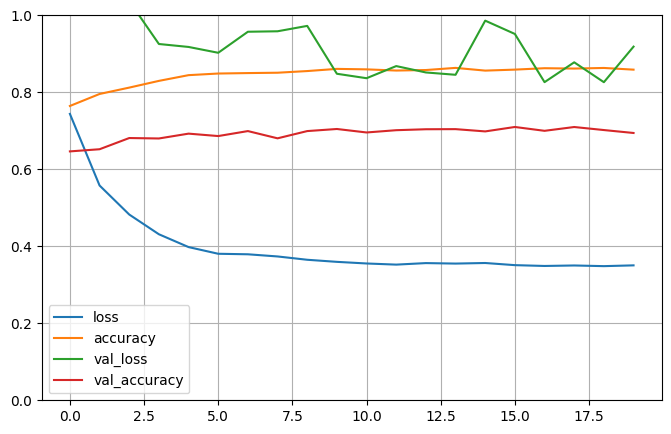

Compute valiation accuracy
2022-10-21 09:34:57.372725
accuracy: 69.43%
2022-10-21 09:34:57.929834

Cross validation acc mean 66.72% (+/- 3.90%)
2022-10-21 09:34:57.933546


In [9]:
print(datetime.now())
do_cross_validation(splitter,EPOCHS)    
print(datetime.now())